In [34]:
from util import *
import numpy as np
from matplotlib import pyplot as plt

from util_cleaning import *
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler



from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf

In [14]:
features = pd.read_csv(DATABASE_PATH + 'cleaned_data/final_3h.csv',';')
features

,full_time,power_consummption,temperature,humidity,visibility,nebulosity
0,2007-01-01 00:00:00,2.552122,286.65,89.0,20000.0,2.0
1,2007-01-01 03:00:00,2.497878,285.65,80.0,20000.0,2.0
2,2007-01-01 06:00:00,2.448244,283.65,77.0,20000.0,2.0
3,2007-01-01 09:00:00,2.794622,282.05,76.0,17000.0,2.0
4,2007-01-01 12:00:00,2.024222,283.65,62.0,25000.0,1.0
...,...,...,...,...,...,...
8746,2009-12-31 09:00:00,1.852422,280.35,93.0,16000.0,5.0
8747,2009-12-31 12:00:00,1.644028,279.95,93.0,8000.0,4.0
8748,2009-12-31 15:00:00,1.582144,277.15,94.0,5000.0,4.0
8749,2009-12-31 18:00:00,2.948644,275.45,96.0,3000.0,4.0


In [12]:
dff = df.copy()

# data_set processes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002982138D188>,
      dtype=object)

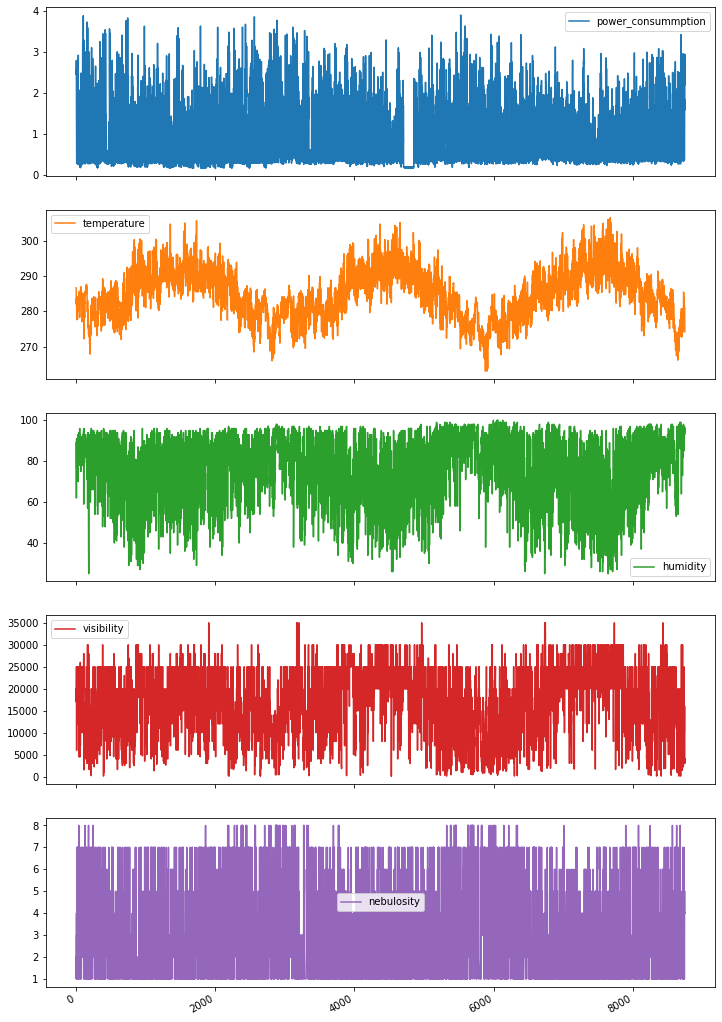

In [17]:
features.plot(subplots=True,figsize = (12,20))

In [84]:
TRAIN_SPLIT = int(df.shape[0]*0.7)
past_history = 30
future_target = 1
STEP = 1
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 30

In [98]:
dataset = dataset.astype('float'
                    )
dataset


array([[ 1.45453317,  1.4673334 ,  0.72372619,  0.59182651, -0.59913394],
       [ 1.39384347,  1.20725928,  0.05613992,  0.59182651, -0.59913394],
       [ 1.33831277,  0.68711106, -0.16638884,  0.59182651, -0.59913394],
       ...,
       [ 0.36930388, -1.00337067,  1.09460746, -1.59116345,  0.41028008],
       [ 1.89816966, -1.44549667,  1.24295996, -1.88222878,  0.41028008],
       [ 1.06065926, -1.7575856 ,  1.16878371, -1.73669612,  0.41028008]])

In [85]:
# dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)


In [86]:
dataset = (dataset-data_mean)/data_std

In [87]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [88]:
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [89]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (30, 5)


In [56]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 30

In [90]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [91]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(64,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(32,activation = 'relu'))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.add(tf.keras.layers.Dropout(0.2))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [92]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [93]:
single_step_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
_________________________________________________________________
dropout_2 (Dropout)          (None, 1)                 0         
Total params: 20,033
Trainable params: 20,033
Non-trainable params: 0
_________________________________________________________________


In [94]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/30
200/200 [==============================] - 18s 92ms/step - loss: 0.6903 - val_loss: 0.7951
Epoch 2/30
200/200 [==============================] - 13s 67ms/step - loss: 0.5317 - val_loss: 0.8332
Epoch 3/30
200/200 [==============================] - 13s 67ms/step - loss: 0.4598 - val_loss: 0.9526
Epoch 4/30
200/200 [==============================] - 14s 68ms/step - loss: 0.4121 - val_loss: 0.9781
Epoch 5/30
200/200 [==============================] - 14s 69ms/step - loss: 0.3738 - val_loss: 0.9514
Epoch 6/30
200/200 [==============================] - 14s 68ms/step - loss: 0.3521 - val_loss: 0.9423
Epoch 7/30
200/200 [==============================] - 14s 68ms/step - loss: 0.3331 - val_loss: 0.9214
Epoch 8/30
200/200 [==============================] - 14s 69ms/step - loss: 0.3179 - val_loss: 0.9547
Epoch 9/30
200/200 [==============================] - 14s 71ms/step - loss: 0.3016 - val_loss: 0.8869
Epoch 10/30
200/200 [==================

In [40]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

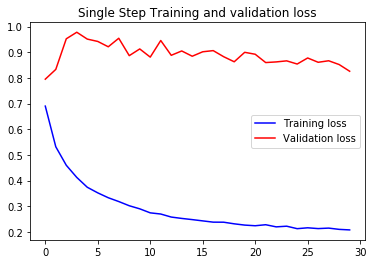

In [95]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [63]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [64]:
def create_time_steps(length):
    return list(range(-length, 0))

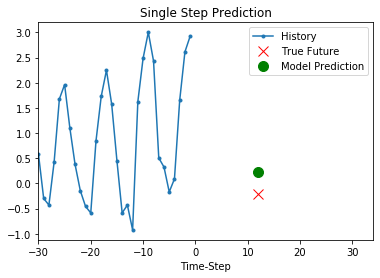

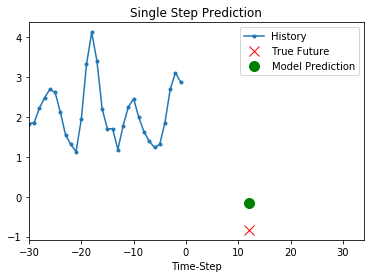

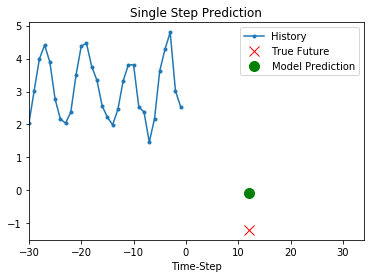

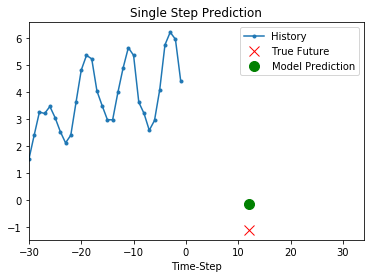

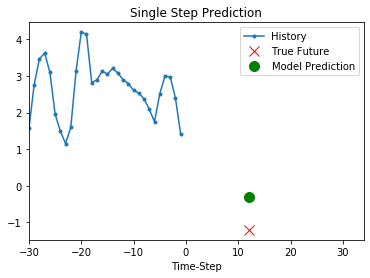

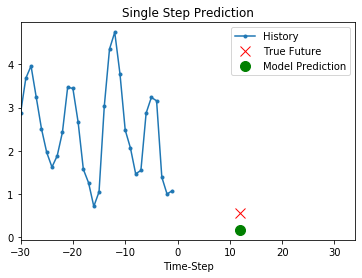

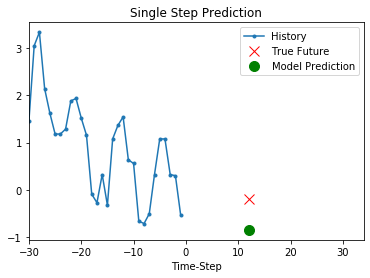

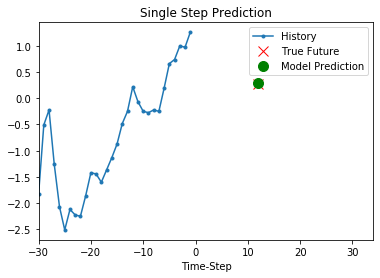

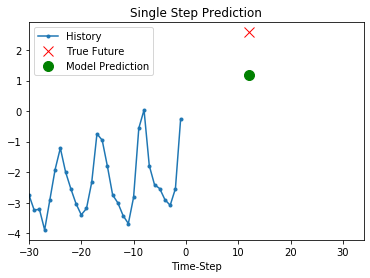

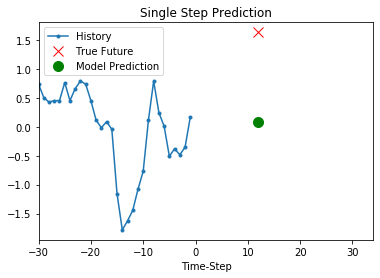

In [97]:
for x, y in val_data_single.take(10):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12
                     ,
                   'Single Step Prediction')
    plot.show()

In [80]:
x_train_single.shape

(971, 15, 5)